In [1]:
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import torchvision
import torch
from FeatureEngineeringUtils.btc_feature_engineering_utils import TrainTestValidationLoader
from numpy.random import permutation
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import numpy as np
import random 
import time
import os
from ModelingUtils.models import CandlesDataset, ConvCandlesDataset, WideDeepLSTMNet, ConvWideDeepLSTMNet, train_epoch, test_epoch, save_model_on_validation_improvement, \
                   load_model, predict, VariationalAutoencoder, FullyConnectedNet, vae_train_epoch, vae_test_epoch, save_vae_on_validation_improvement, evaluate

In [2]:
data_loader = TrainTestValidationLoader('btc_4h_for_target1_1', target='target1', training_portion=0.75, validation_portion=0.4, original_time_frame=240, n_input_steps=50)

train_features, train_labels = data_loader.get_reframed_train_data()
train_dataset = ConvCandlesDataset(train_features, train_labels.reshape(-1, 1))

test_features, test_labels = data_loader.get_reframed_test_data()
test_dataset = ConvCandlesDataset(test_features, test_labels.reshape(-1, 1))

val_features, val_labels = data_loader.get_reframed_val_data()
val_dataset = ConvCandlesDataset(val_features, val_labels.reshape(-1, 1))

batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [3]:
torch.manual_seed(1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


input_dim = np.shape(train_features)[2]
cwdn = ConvWideDeepLSTMNet(input_dim=input_dim, device=device)

loss_fn1 = nn.MSELoss(reduction='mean')
loss_fn2 = nn.L1Loss(reduction='mean')

lr = 2e-3
adam_optimizer = torch.optim.Adam(cwdn.parameters(), lr=lr, weight_decay=4e-4)

cwdn.to(device, dtype=torch.double)

Selected device: cuda


ConvWideDeepLSTMNet(
  (conv_net): ConvNet(
    (conv1): Conv2d(1, 24, kernel_size=(3, 31), stride=(1, 1), padding=(1, 0))
    (max1): MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (batch1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(24, 48, kernel_size=(3, 31), stride=(1, 1), padding=(1, 0))
    (conv3): Conv3d(1, 1, kernel_size=(48, 1, 1), stride=(1, 1, 1))
    (batch2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deep_lstm): DeepLSTMNet(
    (l1): LSTMCell(12, 90)
    (l2): LSTMCell(90, 66)
    (l3): LSTMCell(66, 48)
    (l4): LSTMCell(48, 24)
    (fc): Linear(in_features=24, out_features=1, bias=True)
  )
  (wide_lstm): WideLSTMNet(
    (lstm): LSTM(12, 110, batch_first=True)
    (fc): Linear(in_features=110, out_features=1, bias=True)
  )
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [4]:
best_loss = np.inf
patience = 5
last_improvement = 0

num_epochs = 50
epoch = 0
flag = True
while flag is True:
    start_time = time.time()
    
    total_loss_train = train_epoch(cwdn, device, train_loader, loss_fn1, loss_fn2, optimizer=adam_optimizer)
    total_loss_test = test_epoch(cwdn, device, test_loader, loss_fn1, loss_fn2)
    
    if epoch % 1 == 0:
        print('\n EPOCH {}/{} \t total_train {:.7f} \t total_test {:.7f} \t execution time: {:.0f}'.format(epoch + 1, num_epochs, total_loss_train, total_loss_test, (time.time() - start_time)))
    
    if total_loss_test < best_loss:
        save_model_on_validation_improvement(cwdn, adam_optimizer, epoch, 'cwdn50')
        best_loss = total_loss_test
        last_improvement = epoch
    
    if epoch - last_improvement > patience:
        flag = False
    
    if epoch >= num_epochs:
        flag = False
    epoch = epoch + 1


 EPOCH 1/50 	 total_train 0.0067134 	 total_test 0.0057129 	 execution time: 96

 EPOCH 2/50 	 total_train 0.0058663 	 total_test 0.0054486 	 execution time: 97

 EPOCH 3/50 	 total_train 0.0057446 	 total_test 0.0056166 	 execution time: 97

 EPOCH 4/50 	 total_train 0.0055747 	 total_test 0.0053639 	 execution time: 97

 EPOCH 5/50 	 total_train 0.0055539 	 total_test 0.0053322 	 execution time: 97

 EPOCH 6/50 	 total_train 0.0053697 	 total_test 0.0054302 	 execution time: 97

 EPOCH 7/50 	 total_train 0.0052280 	 total_test 0.0054056 	 execution time: 97

 EPOCH 8/50 	 total_train 0.0051624 	 total_test 0.0056474 	 execution time: 97

 EPOCH 9/50 	 total_train 0.0050301 	 total_test 0.0058538 	 execution time: 97

 EPOCH 10/50 	 total_train 0.0049749 	 total_test 0.0057032 	 execution time: 97

 EPOCH 11/50 	 total_train 0.0048413 	 total_test 0.0061410 	 execution time: 97


In [5]:
model, adam_optimizer = load_model('torch_models//cwdn50.pth', cwdn, adam_optimizer)

n = 50

In [6]:
train_preds = predict(model, train_dataset, device)

100%|██████████████████████████████████████████████████████████████████████████████| 7089/7089 [02:53<00:00, 40.86it/s]


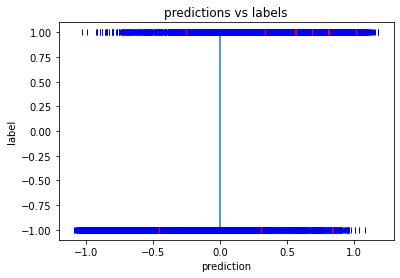

<Figure size 432x288 with 0 Axes>

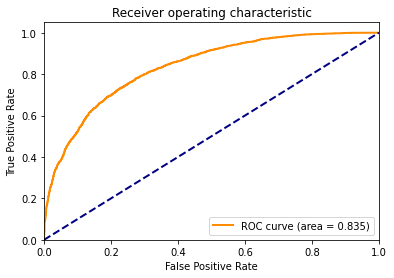

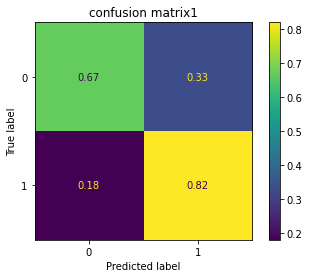

accuracy:  0.7489067569473833
F_score:  0.7369703999539292


(0.8350611576667919, 0.7489067569473833)

In [7]:
evaluate(train_labels.reshape(-1, 1), train_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [8]:
test_preds = predict(model, test_dataset, device)

100%|██████████████████████████████████████████████████████████████████████████████| 1408/1408 [00:35<00:00, 39.56it/s]


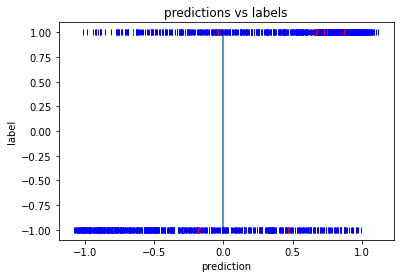

<Figure size 432x288 with 0 Axes>

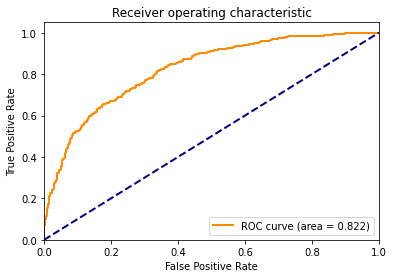

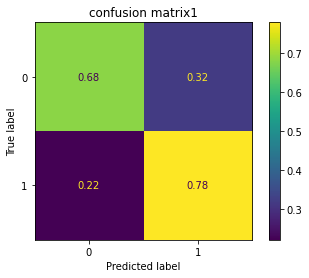

accuracy:  0.7350852272727273
F_score:  0.7280389203894815


(0.8221607784145468, 0.7350852272727273)

In [9]:
evaluate(test_labels.reshape(-1, 1), test_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [10]:
val_preds = predict(model, val_dataset, device)

100%|████████████████████████████████████████████████████████████████████████████████| 972/972 [00:23<00:00, 41.18it/s]


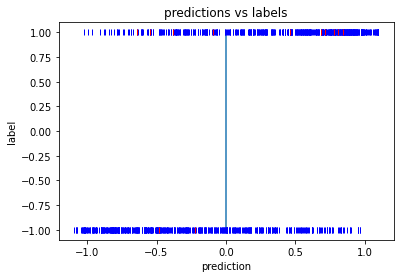

<Figure size 432x288 with 0 Axes>

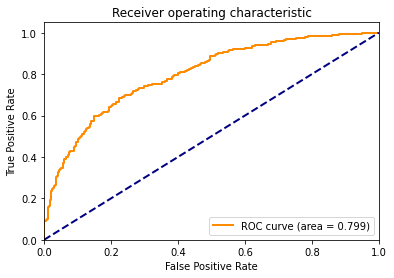

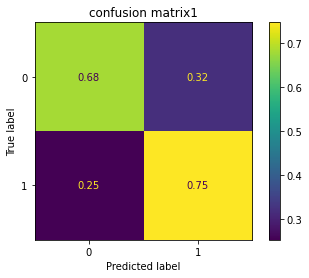

accuracy:  0.7150205761316872
F_score:  0.7122314339267309


(0.7993809231030169, 0.7150205761316872)

In [11]:
evaluate(val_labels.reshape(-1, 1), val_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

n = 21 results

In [7]:
train_preds = predict(model, train_dataset, device)

100%|██████████████████████████████████████████████████████████████████████████████| 7118/7118 [01:27<00:00, 81.14it/s]


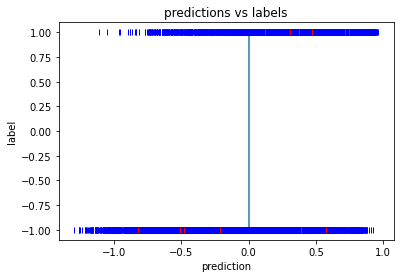

<Figure size 432x288 with 0 Axes>

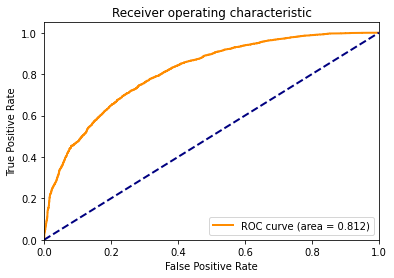

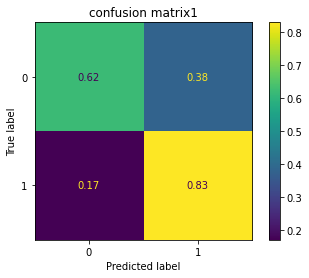

accuracy:  0.7299803315538073
F_score:  0.7087075196324069


(0.8116514807253105, 0.7299803315538073)

In [8]:
evaluate(train_labels.reshape(-1, 1), train_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [9]:
test_preds = predict(model, test_dataset, device)

100%|██████████████████████████████████████████████████████████████████████████████| 1420/1420 [00:17<00:00, 81.46it/s]


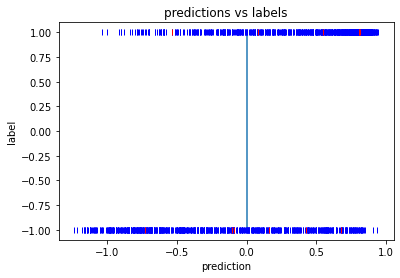

<Figure size 432x288 with 0 Axes>

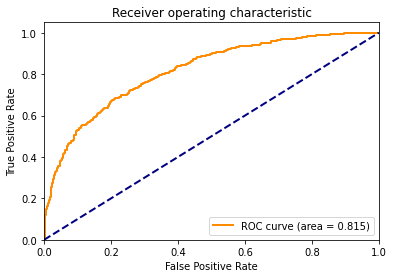

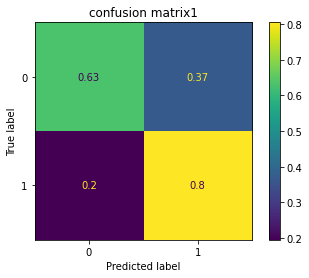

accuracy:  0.726056338028169
F_score:  0.7086109000176437


(0.815150843256049, 0.726056338028169)

In [10]:
evaluate(test_labels.reshape(-1, 1), test_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)

In [11]:
val_preds = predict(model, val_dataset, device)

100%|████████████████████████████████████████████████████████████████████████████████| 960/960 [00:13<00:00, 73.36it/s]


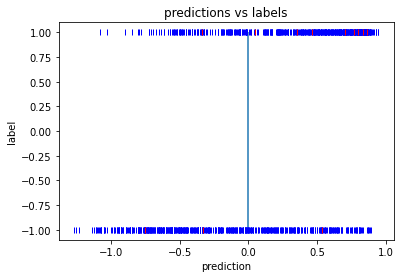

<Figure size 432x288 with 0 Axes>

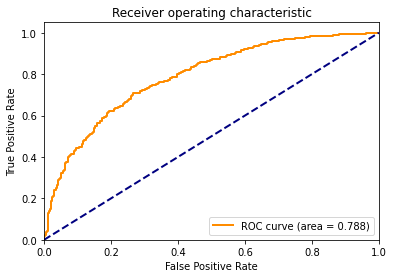

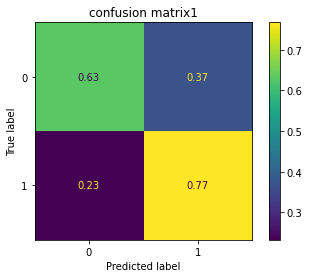

accuracy:  0.7010416666666667
F_score:  0.6921223988686341


(0.7880265015748886, 0.7010416666666667)

In [12]:
evaluate(val_labels.reshape(-1, 1), val_preds.reshape(-1, 1), continuous=False, separator=0, multiclass=False)